# Random ODE Generator

## Setting Problem Up

In [368]:
### Imports ###
import numpy as np
from sympy import *
import sympy
import random as rand
import random
import IPython.display as disp
init_printing()
import matplotlib.pyplot as plt

In [369]:
### Setting predetermined values ###

# Setting the order of the equation (fixed)
n = 3

########

# Number of y-type terms (x, y, y', etc.)
T = n + 2

# Minimum number of subterms total (total number of terms in the final equation)
min_subterms = 2

# Maximum number of subterms total (total number of terms in the final equation)
max_subterms = 3

# Maximum number of times a function recursively called to create a function
max_fun = 2

# Sets the cumulative probabilities for the following function types:
# (1) No change (2) power (3) exponential (4) logarithmic (5) trig (6) hyperbolic
function_cdf = [0.1, 0.5, 0.62, 0.74, 1, 1]

# Sets the probability that the function creating function will recursively call
# itself again
recurs_prob = 0.1

# The probability of adding a constant to the function
add_c_prob = 0.5

In [370]:
### Defining the symbols, functions, and terms ###

# Define symbol and function variables
x = Symbol('x')

# Stores the y-type terms (x, y, y', etc.) in an array called y_terms
y_terms = np.empty(T, dtype=Symbol)
y_terms[0] = x

for i in range(1, T):
    #y_terms[i] = y(x).diff(x, i - 1)
    y_terms[i] = Symbol('y'+str(i-1))
    
y_terms

array([x, y0, y1, y2, y3], dtype=object)

## Functions

In [371]:
def num_subterms (sum_min, sum_max):
    '''
    This creates an array of the number of subterms for each y-type term.
    If the number of subterms is less than the specified minimum or greater than
    the specified maximum, the function will call itself recursively until
    a valid number of subterms are determined.

    Parameters
    ----------
    sum_min:  int
              The minimum number of total subterms
    sum_max:  int
              The maximum number of total subterms

    Returns
    ----------
    temp: numpy array of int
          Returns the number of subterms for each y-type term
    '''

    temp = np.empty(T, dtype=int)
    # Initially set that the nth derivative term has one subterm
    temp[-1] = 1

    # Set number of subterms (0, 1, or 2) for remaining terms
    for i in range(T - 1):
        # Sets the probability of having 0 subterms or 1 subterm
        probabilities = [0] * 1 + [1] * 2
        temp[i] = rand.choice(probabilities)

    if (sum(temp) < sum_min or sum_min > sum_max):
        return num_subterms (sum_min, sum_max)
    # return temp
    return [1, 1, 1, 1, 1] # changed this so every order is present in the final ODE

In [372]:
def generate_random_sympy_polynomial():
    """
    Generates a simple sympy polynomial of x with two or three terms and a maximum power of 4.
    Coefficients range from -5 to 5.

    Returns:
        sympy.Expr: A sympy expression representing the polynomial.
    """

    x = symbols('x')
    num_terms = random.choice([2, 3])
    polynomial = 0

    for _ in range(num_terms):
        coeff = random.choice([i for i in range(-5, 6) if i != 0])
        power = random.randint(0, 4)
        polynomial += coeff * x**power

    return polynomial

# Generate and display a sympy polynomial
random_sympy_polynomial = generate_random_sympy_polynomial()
random_sympy_polynomial



In [373]:
def polynomial_from_coefficients(coefficients, special_func_prob=0.5, power_prob=0.5):
    """
    Converts a list of coefficients into a polynomial expression using sympy.
    Optionally adds a special function to the polynomial.

    Parameters:
    coefficients (list): A list of coefficients, where the index represents the power of x.
    special_func_prob (float): Probability of adding a special function to the polynomial.
    power_prob (float): Probability of raising the special function to a positive power.

    Returns:
    sympy expression: The polynomial expression.
    """
    x = symbols('x')
    polynomial = sum(coef * x**i for i, coef in enumerate(coefficients[::-1]))

    # Check if a special function should be added
    if random.random() < special_func_prob:
        # List of special functions
        special_funcs = [sin(x), cos(x), log(x+1), exp(x)]
        # Choose one special function randomly
        special_func = random.choice(special_funcs)

        # Optionally raise the special function to a positive power
        if random.random() < power_prob:
            power = random.randint(1, 4)  # positive power between 1 and 4
            special_func = special_func**power

        # Add the special function to the polynomial
        polynomial += special_func

    return Poly(polynomial)

In [374]:
def create_subterm (y_term, cdf, iteration, max_it, const_prob):
    '''
    This returns a random subterm (a random function of the given y_term).
    It may recursively call itself to make a more complicated funciton up to
    max_it times.

    The drawable functions include power, exponential, logarithmic,
    trigonometric, and hyperbolic.

    Parameters
    ----------
    y_term:     Object
                The y-type term (x, y, y', etc.)
    cdf:        int
                The cumulative pobability of each function type (power,
                exponential, logarithmic, trigonometric, and hyperbolic)
    iteration:  int
                The iteration number (how many times the function has
                been called)
    max_it:     int
                The maximum number of times the function can be called
    const_prob: float
                The probability of adding a constant to the current subterm

    Returns
    ----------
    subterm:  Object
              Returns a subterm for a function of a given y_term
    '''

    # Default value (function does nothing)
    subterm = y_term

    # RETURNING y3 alone
    if y_term == y_terms[4]:
        return y_terms[4]

    # Randomly determines if a function must be applied (and which function)
    temp = rand.random()
    
    def add_coeff_and_constant(subterm, const_prob):
        # Determines coefficient
        coeffs = np.linspace(-5,-1,11, dtype=int)
        if rand.random() < 0.5:
            subterm *= rand.choice(coeffs)
        # elif rand.random() > 0.8:
        #     subterm /= rand.choice(coeffs)

        # Determines added constant
        if rand.random() < 0.5:
            subterm += rand.choice(coeffs)
            
        return subterm
    
    # New Feature: Raise y, y', or y'' to a positive power
    if y_term in [y_terms[1], y_terms[2], y_terms[3]]:
        if rand.random() < 0.5:  # the probability of raising to a power
            power = rand.randint(1, 3)  # positive power between 1 and 4
            subterm = y_term ** power
        else:
            subterm = generate_random_sympy_polynomial() * y_term

    if y_term == y_terms[0]:
        # Trig
        if temp > 0.5:
            # trig_fun = [sin(y_term)] + [cos(y_term)] + [tan(y_term)]
            trig_fun = [sin(y_term)] + [cos(y_term)]
            subterm = rand.choice(trig_fun)
            subterm = add_coeff_and_constant(subterm, const_prob)
        # Log
        if temp > 0.5:
            subterm = log(y_term+1)
            subterm = add_coeff_and_constant(subterm, const_prob)
        # Exponential
        else:
            subterm = exp(y_term)
            subterm = add_coeff_and_constant(subterm, const_prob)
        # f(x)
        # elif temp > cdf[0]:
        #     coefficients = generate_polynomial(degree=4, num_terms=2,coeff_lower_bound=-3,coeff_upper_bound=3)
        #     subterm = 1 / polynomial_from_coefficients(coefficients) * y_term


    if subterm == 0:
        return create_subterm(y_term, cdf, iteration, max_it, const_prob)

    # Will consider reiterating if we have not yet reached the maximum
    # number of iterations

    # if iteration < max_it:
    #     # If so, will add another function on top of this one
    #     if rand.random() < recurs_prob:
    #         # Recursively calls its own function to
    #         # create a more complicated function
    #         subterm = create_subterm(subterm, cdf, iteration + 1, max_it, const_prob)
    #     # If not, will randomly determine if some additional p(x) should be added
    #     elif rand.random() < 2/3:
    #         # Only p(x)
    #         subterm *= create_subterm(x, cdf, max_it, max_it, const_prob)

    return simplify(subterm)

In [375]:
def create_subterms (y_term, num_sub):
    print(y_term)
    '''
    This returns all subterms of the equation.

    Parameters
    ----------
    y_term:   numpy array of Object
              The y-type terms (x, y, y', etc.)
    num_sub:  numpy array of int
              The number of subterms for each y-type term

    Returns
    ----------
    subterms: numpy array of Object
              Returns all of the subterms for the equation
    '''

    # Stores the subterms
    subterms = np.empty(sum(num_sub), dtype=Mul)

    # Keeps track of index of subterms we are at
    counter = 0

    for i, y_t in enumerate(y_term):
        print(num_sub[i])
        for n_s in range(num_sub[i]):
            # Determines function to be applied to the y_term
            subterms[counter] = create_subterm(y_t, function_cdf, 1, max_fun, add_c_prob)
            counter += 1

    return subterms

## Final Calculation and Output

In [376]:
terms = create_subterms(y_terms, num_subterms(min_subterms, max_subterms))
print("The terms are:")
for i in range(len(terms)):
    disp.display(terms[i])

[x y0 y1 y2 y3]
1
1
1
1
1
The terms are:


In [377]:
sum(terms)

In [378]:
# Define y3 from y_terms
y3 = y_terms[4]
solve(sum(terms),y3, evaluate=False)

In [379]:
new_terms = terms.tolist()
new_terms.remove(y3)
new_terms

In [380]:
y3 = -sum(new_terms)

In [381]:
y3

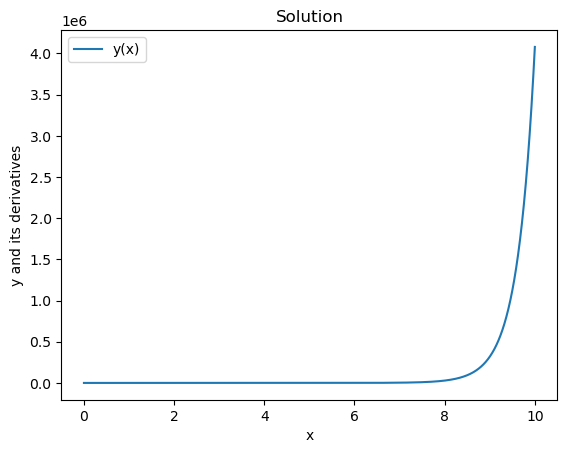

In [382]:
from sympy import symbols, diff, exp
from scipy.integrate import solve_ivp

x = symbols('x')
y0, y1, y2 = symbols('y0 y1 y2')

from sympy.utilities.lambdify import lambdify

# Lambdify the y3 expression so it can be used as a function
y3_func = lambdify((x, y0, y1, y2), y3)

# Define the system of first-order ODEs using y3 directly
def system_of_odes_with_y3(x, y):
    y0, y1, y2 = y
    # Use y3 as a function
    dy2_dx = y3_func(x, y0, y1, y2)
    return [y1, y2, dy2_dx]

initial_conditions = [1, 0, 0]  # placeholder initial conditions
x_range = (0, 10)
X = np.linspace(x_range[0], x_range[1], 10000)


# Solve the system of ODEs
solution_with_y3 = solve_ivp(system_of_odes_with_y3, x_range, initial_conditions, t_eval=X)

plt.plot(solution_with_y3.t, solution_with_y3.y[0], label='y(x)')
# plt.plot(solution_with_y3.t, solution_with_y3.y[1], label="y'(x)")
# plt.plot(solution_with_y3.t, solution_with_y3.y[2], label="y''(x)")
plt.legend()
plt.xlabel('x')
plt.ylabel('y and its derivatives')
plt.title('Solution')
plt.show()


In [383]:
solution_with_y3.y[0]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       4.05831064e+06, 4.06892736e+06, 4.07957238e+06])

In [384]:
def find_divergence_x_value(solution, component_index=0, threshold=1e3):
    y_values = solution.y[component_index]
    for i, y in enumerate(y_values):
        if abs(y) > threshold:
            return solution.t[i]
    return None  # Return None if the solution does not diverge within the given range

# Example usage:
divergence_x = find_divergence_x_value(solution_with_y3, component_index=0)
if divergence_x is not None:
    print(f"The solution diverges at x = {divergence_x}")
else:
    print("The solution does not diverge within the given range")


The solution diverges at x = 6.500650065006501


**Plotting the dominant balances**

In [385]:
terms

array([log(x + 1) - 1, x**2*y0*(1 - x), -2*x**2*y1, 2*y2*(x**2 + 1), y3],
      dtype=object)

In [393]:
from sympy import lambdify, symbols, log
import numpy as np

# Define the symbols used in the expressions
x, y0, y1, y2 = symbols('x y0 y1 y2')

# Your array of expressions
terms = np.array([log(x + 1) - 3, x**2*y0*(x - 4), y1**2, y2*(-4*x**4 - 4*x**3 + 1)], dtype=object)

# Convert each expression to a function
term_funcs = [lambdify((x, y0, y1, y2), term) for term in terms]

# Assuming solution_with_y3 is your solution object from solve_ivp
x_values = solution_with_y3.t
y_values0 = solution_with_y3.y[0]
y_values1 = solution_with_y3.y[1]
y_values2 = solution_with_y3.y[2]

# Evaluate each function with the numerical solutions
evaluated_terms = [func(x_values, y_values0, y_values1, y_values2) for func in term_funcs]

# y_values3 is calculated as the sum of all the other evaluated terms
y_values3 = sum(evaluated_terms)

# Now you can access each term
term1, term2, term3, term4 = evaluated_terms
list_of_terms = [term1, term2, term3, term4]
term5 = y_values3


In [395]:
term5

array([-3.00000000e+00, -2.99800580e+00, -2.99602359e+00, ...,
        1.11154236e+14,  1.11750634e+14,  1.12350116e+14])

In [397]:
term3

array([0.00000000e+00, 2.49600233e-13, 3.98562134e-12, ...,
       1.12392603e+14, 1.12992626e+14, 1.13595784e+14])

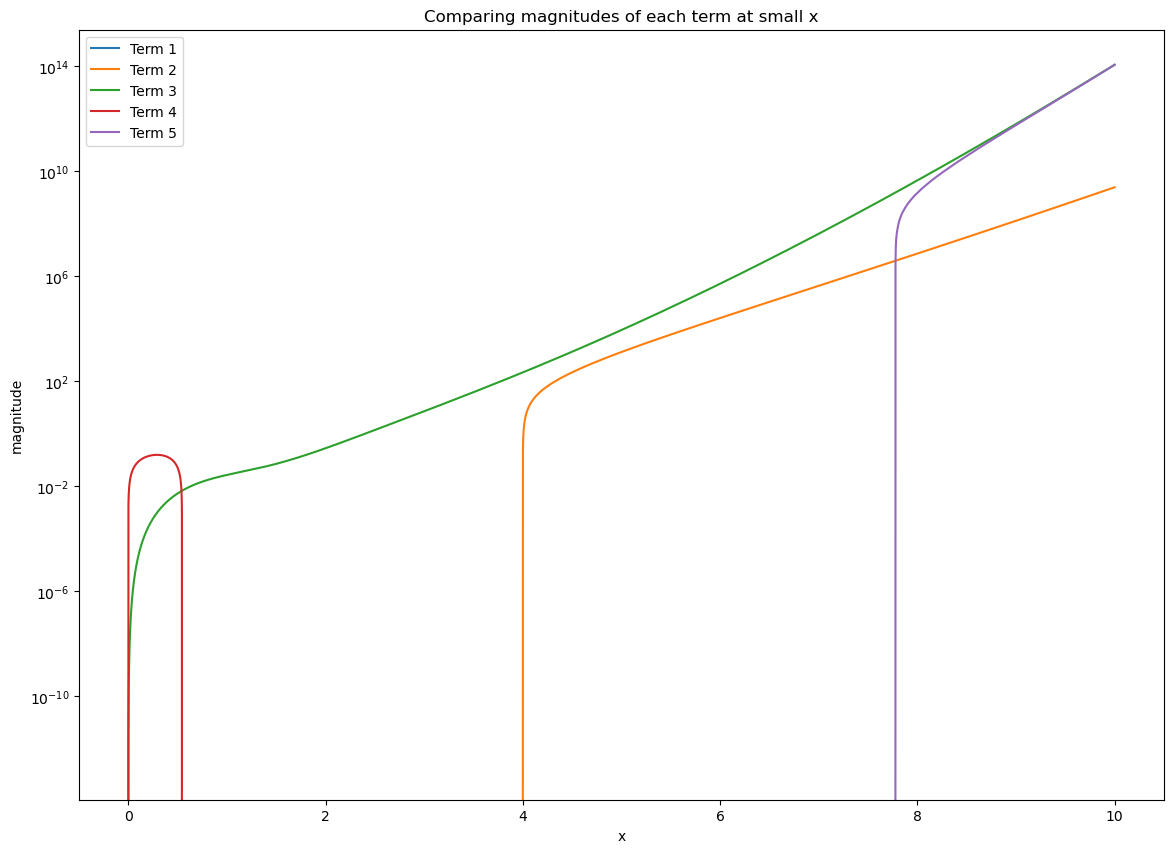

In [398]:
plt.figure(figsize=[14, 10])
for i in range(len(list_of_terms)):
    plt.plot(solution_with_y3.t, list_of_terms[i], label = f"Term {i+1}");

plt.plot(solution_with_y3.t, term5, label = "Term 5");
plt.xlabel('x')
plt.ylabel('magnitude')
# plt.xlim([0,3])
plt.yscale("log")
plt.title("Comparing magnitudes of each term at small x")
plt.legend();